### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [45]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc
import pycbc.psd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [46]:
m = Merger('GW150914') # From the catalogue of all known gravitational wave mergers we pick this one
ifo = 'L1' # The data was take from LIGO Livingston detector
data = m.strain(ifo) # We import the data into this variable

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them. 

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

Alongside the given definitions, sampling rate can be expressed as
$$ sampling\_rate = N / duration $$
then it follows that
$$\Delta_t = duration / N $$
$$\Delta_t = 1 /(\Delta_f * N )$$
$$ N = 1/(\Delta_t * \Delta_f)$$

In [47]:

print("The duration of the time series is: ", data.duration, "s") # calling the duration attribute of the time series
print("The sampling rate is ", data.sample_rate, "Hz")  # calling the sample rate attribute of the time series
print("The amount of data points ", len(data))  # the amount of data points within the array called "data"
print("Delta_f is ", data.delta_f) # spacing between datapoints and spacing between the sampling rates per data point
print("Delta_t is ", data.delta_t)

print(1/(data.delta_f * data.delta_t)) # Print to see if the result of the above equation matches the number of data points

The duration of the time series is:  32.0 s
The sampling rate is  4096.0 Hz
The amount of data points  131072
Delta_f is  0.03125
Delta_t is  0.000244140625
131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

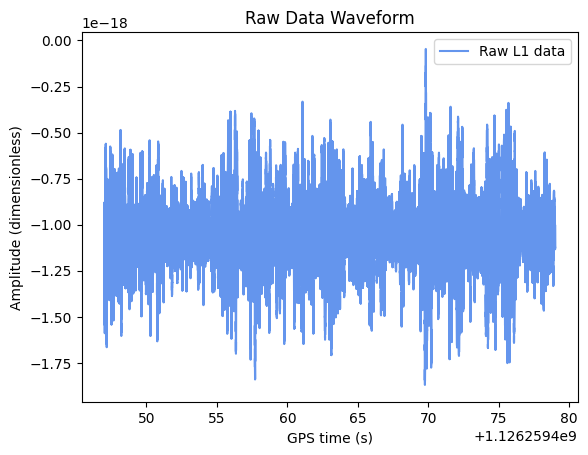

In [48]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.title("Raw Data Waveform")
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton. 

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. 

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency. 

_Hint_: Note that the PSD is a frequency series.

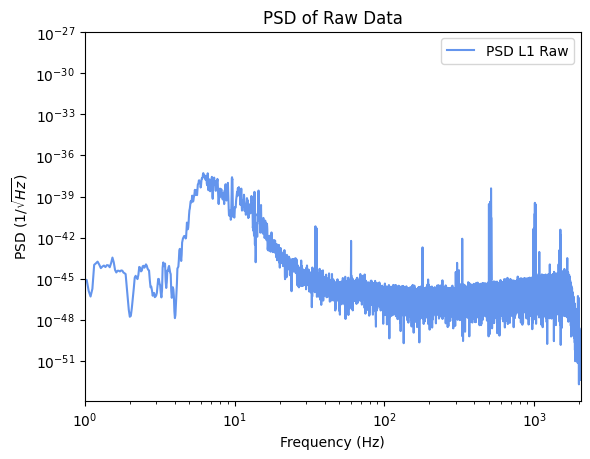

In [49]:
filter_data = data.filter_psd(data.duration, data.delta_f, flow=1) # Estimate the PSD using the function from pycbc, provide the necessary arguments:
# the respective duration and delta_f of the time series, flow is the low frequency cutoff
psd = filter_data.sample_frequencies # Extract the array that contains the sample frequencies from the filter output

fig, ax = plt.subplots()

ax.loglog(psd, filter_data, label='PSD L1 Raw', color='cornflowerblue') # Both axes are scaled to be logarithmic
plt.xlim(1, data.sample_rate/2) # Nyquist frequency is defined to be half of the sampling rate
plt.xlabel("Frequency (Hz)") # Name the axes and include the units
plt.ylabel(r'PSD (1/$\sqrt{Hz}$)')
plt.title("PSD of Raw Data")
plt.legend() # Display the label for the data

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`. 

- Plot the whitened data next to the raw detector noise. What differences can you see?

<span style="color:blue"> The y-axis has changed by 20 orders of magnitude, the oscillations are much more uniform in amplitude, and part of the data is cropped from both ends.</span>

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?

<span style="color:blue"> The PSD for whitened data does not behave erratically for frequencies less than 5 Hz, unlike the PSD for the raw data. The strength of the signal has increased by about 40 orders of magnitude after whitening, as reflected in the y-axis. The PSD also looks more uniform (or flattened) for the whitened data. </span>


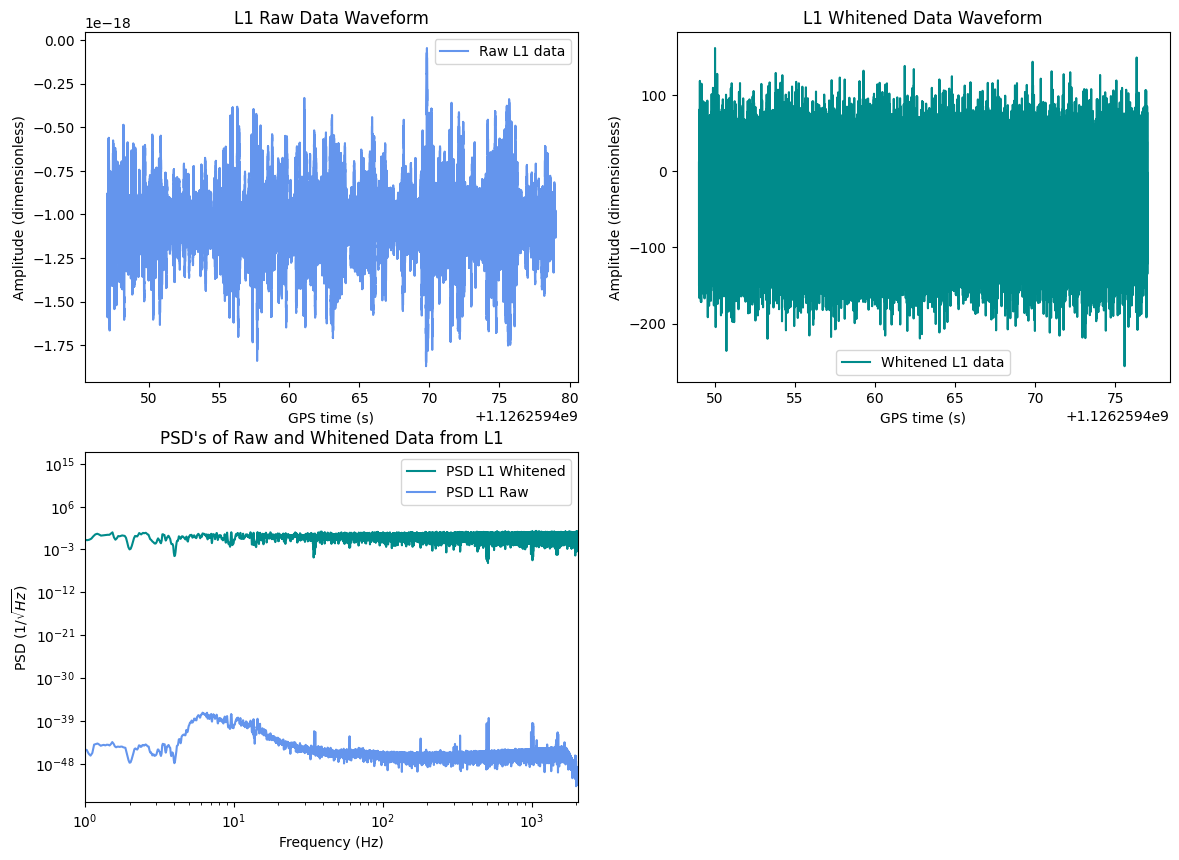

In [50]:
whit_data = data.whiten(segment_duration=4, max_filter_duration=4) # Whiten the previous raw data using the pycbc function and the given arguments

whit_psd = whit_data.filter_psd(whit_data.duration, whit_data.delta_f, flow=1) # Filter the whitened data

plt.figure(figsize=(14,10)) # Set the size of the figure

plt.subplot(2,2,1) # The first plot
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue') # Plot the raw detector noise
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.title("L1 Raw Data Waveform")
plt.legend()

plt.subplot(2,2,2) # The second plot
plt.plot(whit_data.sample_times, whit_data, label='Whitened L1 data', color='darkcyan') # Plot the whitened data
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.title("L1 Whitened Data Waveform")
plt.legend()

plt.subplot(2,2,3) # The third plot
plt.loglog(whit_psd.sample_frequencies, whit_psd, label='PSD L1 Whitened', color='darkcyan') # Plot the PSD of the whitened data together with the PSD of the raw data
plt.loglog(psd, filter_data, label='PSD L1 Raw', color='cornflowerblue')
plt.xlim(1, data.sample_rate/2) # The frequency is limited between 1 Hz and the Nyquist frequency
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'PSD (1/$\sqrt{Hz}$)')
plt.title("PSD's of Raw and Whitened Data from L1")
plt.legend()


Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data. 


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

<span style="color:blue"> The bandpass supresses the frequencies outside of the specified range, this is we set to 30-250 Hz. The higher number in the </span> `order` <span style="color:blue"> argument creates a sharper transition between the bounds of the range and the rest of the data. </span>

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

<span style="color:blue"> After all the whitening and bandpassing, there appears one clear peak in the data. The amplitudes are 20 orders of magnitude larger in the processed data, but also appear more clear due to noise reduction. The raw data plot is dominated by frequencies between 3 and 20 Hz but several peaks appear for values higher than 20 Hz. On the other hand, the bandpassed data is dominated by the frequencies that we specified, which is 30 to 250 Hz. </span>

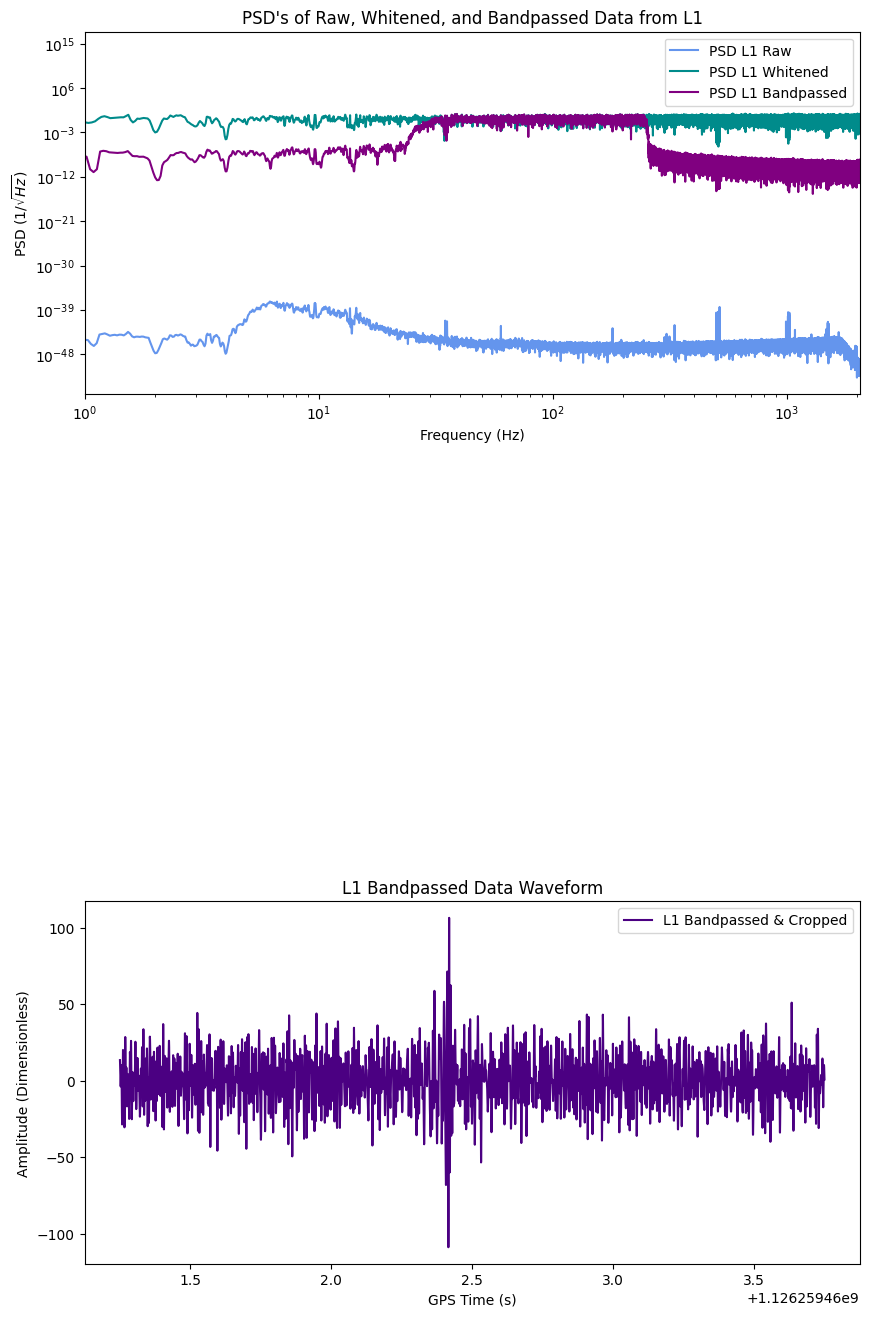

In [51]:
# Do the bandpassing in two steps according to the given parameters
bp_interm = whit_data.lowpass_fir(frequency=250, order=512) # Apply the low pass filter
bp_final = bp_interm.highpass_fir(frequency=30, order=512) # Apply the high pass filter

bp_psd = bp_final.filter_psd(bp_final.duration, bp_final.delta_f, flow=1) # Find the psd of the bandpassed data

plt.figure(figsize= (10,16))
plt.subplot(3,1,1) # Plot all three PSD's: raw, whitened, and bandpassed data sets
plt.loglog(psd, filter_data, label='PSD L1 Raw', color='cornflowerblue') 
plt.loglog(whit_psd.sample_frequencies, whit_psd, label='PSD L1 Whitened', color='darkcyan')
plt.loglog(bp_psd.sample_frequencies, bp_psd, label='PSD L1 Bandpassed', color='purple')
plt.xlim(1, data.sample_rate/2) # Same configurations as previous PSD plots
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'PSD (1/$\sqrt{Hz}$)')
plt.title("PSD's of Raw, Whitened, and Bandpassed Data from L1")
plt.legend()

plt.subplot(3,1,3) # Plot the amplitude/time for the bandpassed data
cropped_bp = bp_final.crop(12, 13) # 12 seconds cropped from the beginning and 13 second cropped from the end
# This cropping gets rid of the corrupted parts of the data caused by the transformations
plt.xlabel("GPS Time (s)")
plt.ylabel("Amplitude (Dimensionless)")
plt.plot(cropped_bp.sample_times, cropped_bp, label='L1 Bandpassed & Cropped', color='indigo')
plt.title("L1 Bandpassed Data Waveform")
plt.legend()


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

<span style="color:blue"> The spectrogram allows us to track how signal strength changes over frequencies and time. 
There is a vertical bright line in the middle of the plot, which shows that a range of frequencies from about 25 Hz to 220 Hz get stronger for a short time. This should be the gravitational wave signal we expect.

Information on spectrograms referenced from: https://vibrationresearch.com/blog/what-is-a-spectrogram/ (Accessed 17 Feb. 2025) </span>

Text(0.5, 1.0, 'Spectrogram of L1 Whitened Data')

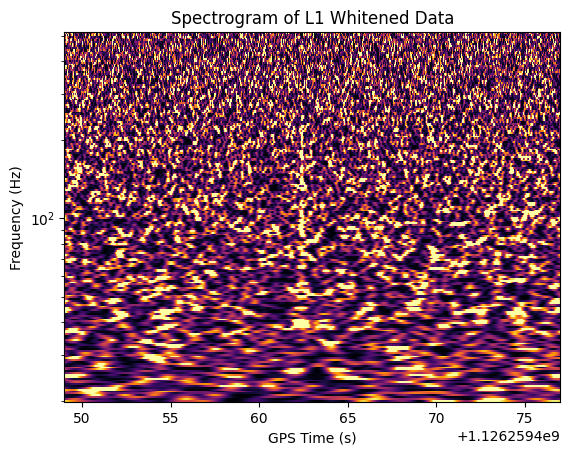

In [52]:
times, freqs, qplane = whit_data.qtransform(delta_t=whit_data.delta_t, logfsteps=200, frange=(20,512), qrange=(110, 110))
# set the arguments as the given values
plt.pcolormesh(times, freqs, qplane, vmax=3.5, cmap="inferno")
plt.xlabel("GPS Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale("log") # Set the y-axis to scale logarithmically
plt.title("Spectrogram of L1 Whitened Data")


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

<span style="color:blue"> The PSD curves for ET and CE are 4-5 orders of magnitude smaller than the existing detectors. This shows that within the frequency interval shown, these two detectors pick up fewer noise signals than the rest. Therefore, we can expect ET and CE to be more sensitive and accurate in picking up gravitational wave signals within the determined frequency range. </span>

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_93278/1698918243.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  psd_V1 = pd.read_csv(file_V1, delim_whitespace = "True", header=None, names=["Freqs", "PSD"]) # name the data columns to refer to them later


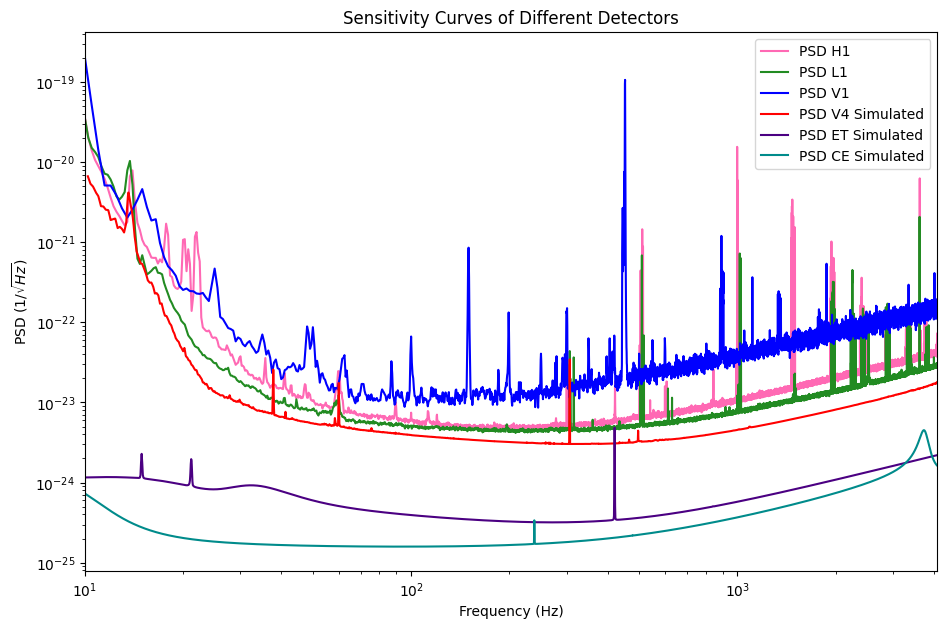

In [55]:
# Download the data files and define the pathnames as variables

file_H1= "aligo_O3actual_H1.txt"
file_L1= "aligo_O3actual_L1.txt"
file_V1= "avirgo_O3actual.txt"
file_V4sim = "aligo_O4high.txt"

files = [file_H1, file_L1, file_V1, file_V4sim] # Store the file names in an array to loop over


sampling_rate = 8192 # Define as given
duration = 16
deltaf = 1/duration #as defined in the first part

file_len = [] # Array to store the number of lines in each data file

# Loop to count the length of the data files - inspiration taken from ChatGPT
for i in files:
    with open(i, "r") as f:
        file_len.append(sum(1 for _ in f))


# Get the PSD's of each data set - code partially taken from Laura Bryan

# Use pandas library to read the data columns from the txt files
psd_H1 = pd.read_csv(file_H1, sep=" ", header=None, names=["Freqs", "PSD"]) # columns are separated by white space
psd_L1 = pd.read_csv(file_L1, sep=" ", header=None, names=["Freqs", "PSD"]) # there's not header in the files
psd_V1 = pd.read_csv(file_V1, delim_whitespace = "True", header=None, names=["Freqs", "PSD"]) # name the data columns to refer to them later
psd_V4sim = pd.read_csv(file_V4sim, sep=" ", header=None, names=["Freqs", "PSD"])

# Generate the simulated PSD's for ET and CE
psd_ETsim =  pycbc.psd.analytical.EinsteinTelescopeP1600143(80000, deltaf, 10) # Create 80k data points with 1/16 frequency resolution, low cutoff at 10 Hz
psd_CEsim =  pycbc.psd.analytical.CosmicExplorerP1600143(80000, deltaf, 10) # Same procedure for CE
psd_ETsim_asd = np.sqrt(psd_ETsim) # Take the square root to match the units and orders of magnitude
psd_CEsim_asd = np.sqrt(psd_CEsim)

# Determine figure size
plt.figure(figsize=(11,7))

# Plot all the PSD curves on log-scaled axes
plt.loglog(psd_H1["Freqs"], psd_H1["PSD"], label='PSD H1', color='hotpink')
plt.loglog(psd_L1["Freqs"], psd_L1["PSD"], label='PSD L1', color='forestgreen')
plt.loglog(psd_V1["Freqs"], psd_V1["PSD"], label='PSD V1', color='blue')
plt.loglog(psd_V4sim["Freqs"], psd_V4sim["PSD"], label='PSD V4 Simulated', color='red')
plt.loglog(psd_ETsim.sample_frequencies, psd_ETsim_asd, label='PSD ET Simulated', color='indigo')
plt.loglog(psd_CEsim.sample_frequencies, psd_CEsim_asd, label='PSD CE Simulated', color='darkcyan')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'PSD (1/$\sqrt{Hz}$)')
plt.xlim(10, sampling_rate/2) # The frequencies are limited between 10 Hz and Nyquist frequency
plt.title("Sensitivity Curves of Different Detectors")
plt.legend()


Good job! This is the end of the second part. Maybe you can go for a break?